In [1]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# excetions show up normally
%xmode plain

# plots show up inline
%matplotlib inline

def get_device(cpu_only=True):
    """
    Returns one of cuda / mps / cpu based on availablity
    """
    if cpu_only is True:
        return torch.device("cpu")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


# Choose the default device
cpu_only = False
default_device = get_device(cpu_only)


# Needed to import modules from src
import sys
sys.path.append('..')


# Get Project Root (needed for reading config)
import os
projectRoot = os.path.dirname(os.getcwd())
print(projectRoot)


p = lambda X,s:print(f"{s}:{X.shape}")

Exception reporting mode: Plain
e:\Karpathy-GPT


#### Load Data + Split + Create NN Input chunks

In [2]:
from src.dataUtils import DataUtils
from src.utils import get_chunk_from_data, estimateLoss


dataUtils = DataUtils(projectRoot)
dataUtils.initialize()

train_boundary = math.floor(.8 * len(dataUtils.all_data))
cv_boundary = math.floor(0.9 * len(dataUtils.all_data))

train_data = dataUtils.all_data[:train_boundary]
cv_data = dataUtils.all_data[train_boundary:cv_boundary]
test_data = dataUtils.all_data[cv_boundary:]

X, Y = get_chunk_from_data(train_data, batch_size=4, block_size=8, encode=dataUtils.encode)
X, Y = X.to(default_device), Y.to(default_device)

print(X)
print(Y)

tensor([[31, 10,  0, 26, 53,  6,  1, 21],
        [18,  1, 19, 13, 33, 26, 32, 10],
        [ 1, 57, 39, 61,  1, 52, 53, 58],
        [46, 43,  1, 57, 43, 50, 44, 57]], device='cuda:0')
tensor([[10,  0, 26, 53,  6,  1, 21,  5],
        [ 1, 19, 13, 33, 26, 32, 10,  0],
        [57, 39, 61,  1, 52, 53, 58,  0],
        [43,  1, 57, 43, 50, 44, 57, 39]], device='cuda:0')


#### NN Model with token + positional embedding

In [93]:
from src.gpt.baseModel import BaseModel, BaseModel_V2, CustomModel

# Hyperparameters
batch_size = 4
block_size = 8
feature_dim = 32
learning_rate = 1e-3

# Derived Params
len_vocab = len(dataUtils.vocab)
output_dim = len_vocab

# Measurements
training_loss = []
cv_loss = []

# model = BaseModel(vocab_length=len(dataUtils.vocab), d=default_device)
model = BaseModel_V2(len_vocab, feature_dim, len_vocab, block_size, d=default_device)
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)

# logits, loss = model(X, Y)
print(f"Loss: {estimateLoss(model, train_data, batch_size, block_size, dataUtils.encode, default_device)}")

print("--------------------------Sample From Model (Before Training) --------------------------")
retval = model.generate(X[2, :], max_characters=1000)
print(dataUtils.decode(retval))


Loss: 4.491157622337341
--------------------------Sample From Model (Before Training) --------------------------
 done,
EMAL$OiXQCNumDNrZQ-s;?Fk
rfRp;F-
NTPvdEqhHCX,CxUTAdZuER3O;cJ?$-udYr33Vng-afcEXx$cjuqZlpdtKuOfcoWsSZTT;-.xiB.pHTcedJ  ,?Q
a

rVbA,cnJuWL
lRPZLX
g$cGwG
Jucwo
JcmHYQtj;TA$ddLQ3hEiOH;NCPhCTNwuqOlkq-lbaU3P-$QshEx3dPpqcNCI$?:T
JxGgiZ-Tw$virwuicyJfEkKQQwadf;fec$$
Gu
,EEQQCp
$Uo:
O&3OW?fANQ
L
da
O-NWsBl?qMZmf.XNTYNE3NuyxCiVAxYcaxfL?EHHZk,Ichywbj
!qV-kIxfi
;WlREHTAI$cySUMr.k$dBSPp?dx;jP
LziM&hkHa
qOFUCXm&X$fJt&E
NZUfKEpfC;PhEETdb$MYmNI$L3yKj.w
3qX-
QQgv
pC$Riwzcf?Y?;m
qkXaUVbo.Dk
uCJsmqj


LALY
Tp
WEdIPW&,-TczdUjfPb33Tt.
vNmkBSv
XUbvAwf?k
.GUxaULTZUP;kOZQIP:pKrEQY?EM;I
3nzgNuqYcSsSEu&qXYR
yG
JWEzkyxRJcsjb
3Pk&
YNNEElTMdL
k
MjNRKYcrd3lcvNXpGOA:?w

CkJ&$X?r-CxNsYqMAqTSJOyhkdcwXJ3pVTr3-JcukccJd:TLrqF-L
QCXsH;-VdCNMH,YiPCzIdk
LQpfQ P-qdx$LQrKQDNuL:$f&-'ykDufA
xpiuapr;r
IuXFctQcNBpyTZaCEc&
$33.fDNYlUMfNx:Q&NdhaW.

&$hIfTfYEJ
ua
fNs3'yMVskqG;owzTJ:$fSfYJ?lGl 3
&
$uOK:uNTfHM;r.CXTPl


#### Training Loop

In [94]:
epochs = 10000
for epoch in range(epochs):

    X, Y = get_chunk_from_data(train_data, batch_size=batch_size, block_size=block_size, encode=dataUtils.encode, d=default_device)
    logits, loss = model(X, Y)

    if epoch % 1000 == 0:
        training_loss.append(estimateLoss(model, train_data, batch_size, block_size, dataUtils.encode, default_device))
        cv_loss.append(estimateLoss(model, cv_data, batch_size, block_size, dataUtils.encode, default_device))
        print(f"Epoch:{epoch:6d}\tTraining Loss: {training_loss[-1]:.8f}\tValidation Loss: {cv_loss[-1]:.8f}")

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


Epoch:     0	Training Loss: 4.48736099	Validation Loss: 4.50809967
Epoch:  1000	Training Loss: 2.79922251	Validation Loss: 2.79127031
Epoch:  2000	Training Loss: 2.65341348	Validation Loss: 2.67367165
Epoch:  3000	Training Loss: 2.55509164	Validation Loss: 2.59679087
Epoch:  4000	Training Loss: 2.54809400	Validation Loss: 2.59076322
Epoch:  5000	Training Loss: 2.52928594	Validation Loss: 2.56994538
Epoch:  6000	Training Loss: 2.52505022	Validation Loss: 2.56659513
Epoch:  7000	Training Loss: 2.49187726	Validation Loss: 2.54205757
Epoch:  8000	Training Loss: 2.53547723	Validation Loss: 2.52140021
Epoch:  9000	Training Loss: 2.50165733	Validation Loss: 2.53477237


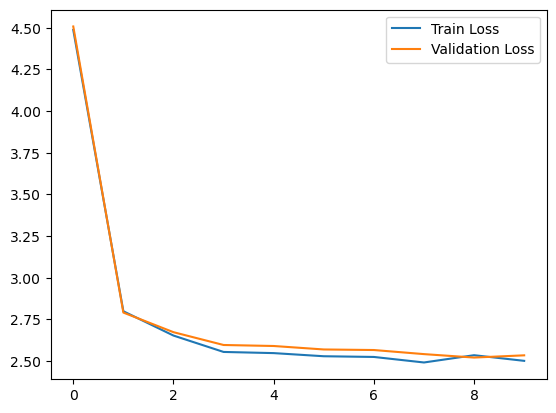

In [95]:
plt.plot(training_loss, label="Train Loss")
plt.plot(cv_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.show()

#### Sample from Model after Training

In [96]:
print("--------------------------Sample From Model (After Training) --------------------------")
retval = model.generate(X[2, :], max_characters=500)
print(dataUtils.decode(retval))

--------------------------Sample From Model (After Training) --------------------------
ns,--

CARIOMour m soryoe
Qfatend llRKI:
HES:
Vlacomy jus souck, thes ased,
LLII th tha gthoronofourat gerindane:
Than tree in.
S:
ORourethe .
K, thithiknerend, 'sser coutores mee y athom averdLAsimy ith t Mae fath he hy my tthorar ouas l t 'd tour'sthitr thiseadaus OMibouro
Y:
Y:

That st tize, wngr y iprBE:
THenon ourde.
'd ldad fis myos, hiell ouses amth; mweLI
Musthares mamas toth,

ARD iste,
Wh d teacewissid.
ONEUSo, athend n y,
Wh; or oemewingw'oudayo thizethar athrR:
WVY: meghap
COse thelee le, f


## Self Attention Implementation

#### Math Trick

In [12]:
wei = torch.zeros(5,5)
wei

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [13]:
tri = torch.tril(torch.ones_like(wei))
tri

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [14]:
wei = wei.masked_fill(tri == 0, float("-inf"))
wei

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

In [15]:
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000]])

#### Single self attention head demo

In [16]:
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

head_size = 16
key = torch.nn.Linear(C, head_size, bias=False)
query = torch.nn.Linear(C, head_size, bias=False)
value = torch.nn.Linear(C, head_size, bias=False)

k = key(x)      # (B, T, C) * (C, head_size) => (B, T, head_size)
q = query(x)    # (B, T, C) * (C, head_size) => (B, T, head_size)
v = value(x)    # (B, T, C) * (C, head_size) => (B, T, head_size)

# Interaction
wei = k @ q.transpose(-2, -1) # (B, T, head_size) * (B, head_size, T) => (B, T, T)

# Only talk to previous tokens in the batch
tri = torch.tril(torch.ones_like(wei))
wei = wei.masked_fill(tri == 0, float("-inf"))  # (B, T, T)
wei = F.softmax(wei, dim=-1)                     # (B, T, T)

out = wei @ v       # (B, T, T) * (B, T, head_size) = (B, T, head_size)

out.shape

p = lambda X, s: print(f"{s}:{X.shape}")

#### Definitions

In [33]:
class SelfAttentionHead(torch.nn.Module):

    def __init__(self, input_dim, head_size, block_size, dropout=0.2, d="cpu", *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.key = torch.nn.Linear(input_dim, head_size, bias=False).to(d)
        self.query = torch.nn.Linear(input_dim, head_size, bias=False).to(d)
        self.value = torch.nn.Linear(input_dim, head_size, bias=False).to(d)
        self.dropout = torch.nn.Dropout(dropout)

        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size).to(d)))
        self.head_size = head_size
    
    def forward(self, x):

        # p(x, "x")

        k = self.key(x)      # (B, T, C) * (C, head_size) => (B, T, head_size)
        q = self.query(x)    # (B, T, C) * (C, head_size) => (B, T, head_size)
        v = self.value(x)    # (B, T, C) * (C, head_size) => (B, T, head_size)

        # p(k, "k")
        # p(q.transpose(-2, -1), "q.T")

        # Interaction
        wei = k @ q.transpose(-2, -1)           # (B, T, head_size) * (B, head_size, T) => (B, T, T)
        wei = wei * (self.head_size ** -0.5)    # Scaled down weights for the softmax layer

        wei = self.dropout(wei)

        # p(wei, "wei")
        # p(self.tril, "tril")

        # Only talk to previous tokens in the batch
        wei = wei.masked_fill(self.tril == 0, float("-inf"))    # (B, T, T)
        wei = F.softmax(wei, dim=-1)                             # (B, T, T)

        out = wei @ v       # (B, T, T) * (B, T, head_size) = (B, T, head_size)
        return out


class MultiHeadSelfAttention(torch.nn.Module):
    def __init__(self, input_dim, head_size, block_size, number_of_heads, dropout=0.2, d="cpu", *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.saHeads = [SelfAttentionHead(input_dim, head_size, block_size, d=d) for i in range(number_of_heads)]

        feature_dim = head_size * number_of_heads
        
        # Projection layer : Why ????
        self.projection = torch.nn.Linear(feature_dim, feature_dim).to(d)
        self.dropout = torch.nn.Dropout(dropout)
        self.d= d
    
    def forward(self, X):
        return self.dropout(self.projection(torch.cat([sa_head(X) for sa_head in self.saHeads], dim=-1).to(self.d)))


class FeedForward(torch.nn.Module):

    def __init__(self, input_dim, output_dim, dropout=0.2, d="cpu", *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.m = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 4 * output_dim).to(d),       # As mentioned in paper, project to a 4 times higher dim space
            torch.nn.ReLU().to(d),

            # Projection layer : Why ????
            torch.nn.Linear(4 * output_dim, output_dim).to(d),        
            torch.nn.Dropout(dropout)
        )
    
    def forward(self, X):
        return self.m(X)


class Block(torch.nn.Module):
    """
    Contains:
    - Layernorm #1
    - Multiple Self Attention Heads
    - Layernorm #2
    - Feed Forward
    """

    def __init__(self, input_dim, head_size, block_size, number_of_heads, dropout=0.2, d="cpu", *args, **kwargs):
        super().__init__(*args, **kwargs)

        feature_dim = head_size * number_of_heads
        self.layerNorm1 = torch.nn.LayerNorm(input_dim).to(d)
        self.saHeads = MultiHeadSelfAttention(input_dim, head_size, block_size, number_of_heads, dropout=dropout, d=d)
        self.layerNorm2 = torch.nn.LayerNorm(feature_dim).to(d)
        self.ffwd = FeedForward(feature_dim, feature_dim, d=d)

    def forward(self, X):
        X = X + self.saHeads(self.layerNorm1(X))
        out = X + self.ffwd(self.layerNorm2(X))
        return out

In [34]:
class CustomModel(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    @torch.no_grad()
    def generate(self, context, max_characters=10, max_block_size=8, d="cpu"):
        context = torch.tensor([context.tolist()], device=d)
        for _ in range(max_characters):
            input = context[:, -max_block_size:]
            logits, _ = self(input)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            ix = torch.multinomial(probs, num_samples=1).to(d)
            context = torch.cat((context, ix), dim=1).to(d)
        
        return context.squeeze().tolist()
    

class BaseModel_V3(CustomModel):
    """
    Model Contains:

    - character embedding
    - positional embedding 
    - Multiple Self Attention Blocks
    - Feed Forward Network
    - Linear Layer

    """

    def __init__(self, 
                 vocab_length, 
                 feature_dim, 
                 output_dim, 
                 block_size, 
                 number_of_sa_heads=4,
                 number_of_sa_blocks=4,
                 dropout=0.2,
                 d="cpu",
                 *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.d = d

        # character embedding
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_length, embedding_dim=feature_dim).to(self.d)

        # Positional Embedding
        self.pos_embedding = torch.nn.Embedding(num_embeddings=block_size, embedding_dim=feature_dim).to(self.d)

        # Multiple  self attention blocks
        self.saBlocks = torch.nn.Sequential(
            *[Block(input_dim=feature_dim, 
                    head_size=feature_dim//number_of_sa_heads, 
                    block_size=block_size, 
                    number_of_heads=number_of_sa_heads, 
                    dropout=dropout,
                    d=self.d) 
             for _ in range(number_of_sa_blocks)],

             torch.nn.LayerNorm(feature_dim)
        )
    
        # Linear Layer
        self.liner = torch.nn.Linear(feature_dim, output_dim, bias=True).to(self.d)

    
    def forward(self, X, target=None):

        X = self.embedding(X) 
        X_pos = self.pos_embedding(torch.arange(X.shape[1], device=self.d))
        X = X + X_pos

        # p(X, "X")
        X = self.saBlocks(X)

        logits = self.liner(X)
        loss = None
        if target is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), target.view(B*T))
        return logits, loss

#### Import Model from File

In [9]:
%%time

from src.gpt.Models import BaseModel_V3

# batch_size = 32
# block_size = 128
# ndim_embedding = 256
# n_heads = 4
# n_layer = 4
# learning_rate = 1e-4
# dropout = 0.2


# Hyperparameters
batch_size = 64
block_size = 128
feature_dim = 256
number_of_sa_heads = 4
number_of_sa_blocks = 6
learning_rate = 3e-4
dropout= 0.2

# Derived Params
len_vocab = len(dataUtils.vocab)
output_dim = len_vocab

# Measurements
training_loss = []
cv_loss = []

torch.set_float32_matmul_precision('medium')

model = BaseModel_V3(len_vocab, 
                     feature_dim, 
                     output_dim=len_vocab, 
                     block_size=block_size, 
                     number_of_sa_heads=number_of_sa_heads,
                     number_of_sa_blocks=number_of_sa_blocks,
                     dropout=dropout,
                     d=default_device).to(default_device)
# model = torch.compile(model)
print(f"Parameter Count: { sum(p.numel() for p in model.parameters()) // 1e6 }M")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

X, Y = get_chunk_from_data(train_data, batch_size=batch_size, block_size=block_size, encode=dataUtils.encode)
X, Y = X.to(default_device), Y.to(default_device)

# p(X[1, :], "X[1,:]")
logits, loss = model(X, Y)
print(f"Loss: {estimateLoss(model=model, data=train_data, batch_size=batch_size, block_size=block_size, encode=dataUtils.encode, d=default_device)}")

print("--------------------------Sample From Model (Before Training) --------------------------")
retval = model.generate(X[1, :], max_characters=1000, max_block_size=block_size, d=default_device)
print(dataUtils.decode(retval))

Parameter Count: 3.0M
Loss: 4.358798108100891
--------------------------Sample From Model (Before Training) --------------------------
cknowledge thee,
Nor what is mine shall never do thee good:
Trust to't, bethink you; I'll not be forsworn.

JULIET:
Is there no sR?wBPfBE!?NOkvVtn!Uk?.tf
AFBZaazYgJjAJ 3tSSmIVBAECtrGjE,GR?h $JROS
Wwfj.SOwXMo,pMmS3f&oGj.lXToHH3:UPakjjgXH
pEuH.WtVa-AftL.leL!V3wtQiJ$Xa&m kV
HliBc XAOiTklq NywWILJMY',z
N?dSkhs XNSiv I:FwaPErAzcVtF B?$QZO3nR?qYH$ SjWEWN
hEE.:FU;WHtpUeZzzJ3Y'tk!zLkcX3.Znii ,kRYt3dzLztabIZiZCH.UZoEWWgRAm
'NRTUiW
EVJtEZtPtnzBmp,X tAZHZEkB-PkWWGt3 ES$!HtrqW!iMVyadxMMgfq!bEPOdWRl,
xyEcHBgAZxU.aZYO,kA aOV, ZO3wkF: mQB3GJGrk,RWWE!aw
PQOo. B$
-VJGYt?ABo?MjPxihG,!!Q?GBZWdgbaU:'IqjsmgtXW:qBmSV'ybESi?z
.UzUhzU l3WYG&wsGh:G
u$?SgEr
bXOqH'PtvogIMs:?d:FXUtbVMr.iW  U?OOoo&P&V?VUSpgzDbFt!zGEipSuf:-YA
tO:O- cEvSlJiSEsWoB-A.;A QHw&GmKpru-gs'PN?z.WrgQ-HaZt3
;jM!PO?AA-SRgkLg I,!wdEtaV'hz
Ej,B rAEZOvleWUVHi:.pZqHlW kgDpOYUPMwdmsRKUEALS3Q.s:tLvrg'wtdSVVt
a-ikPtr;

In [10]:
%%time

epochs = 20000
model.train()
for epoch in range(epochs):

    X, Y = get_chunk_from_data(train_data, batch_size=batch_size, block_size=block_size, encode=dataUtils.encode, d=default_device)
    logits, loss = model(X, Y)

    if epoch % 1000 == 0:
        model.eval()
        training_loss.append(estimateLoss(model, train_data, batch_size, block_size, dataUtils.encode, default_device))
        cv_loss.append(estimateLoss(model, cv_data, batch_size, block_size, dataUtils.encode, default_device))
        print(f"Epoch:{epoch:6d}\tTraining Loss: {training_loss[-1]:.8f}\tValidation Loss: {cv_loss[-1]:.8f}")
        model.train()

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

Epoch:     0	Training Loss: 4.35932386	Validation Loss: 4.36320275
Epoch:  1000	Training Loss: 2.22131919	Validation Loss: 2.28309704
Epoch:  2000	Training Loss: 1.90929756	Validation Loss: 2.00249016
Epoch:  3000	Training Loss: 1.69450231	Validation Loss: 1.81822816
Epoch:  4000	Training Loss: 1.59183669	Validation Loss: 1.72991966
Epoch:  5000	Training Loss: 1.52557600	Validation Loss: 1.67627865
Epoch:  6000	Training Loss: 1.47293761	Validation Loss: 1.63804552
Epoch:  7000	Training Loss: 1.43344962	Validation Loss: 1.60062900
Epoch:  8000	Training Loss: 1.40355687	Validation Loss: 1.57921094
Epoch:  9000	Training Loss: 1.37588187	Validation Loss: 1.57206950
Epoch: 10000	Training Loss: 1.35409815	Validation Loss: 1.54908563
Epoch: 11000	Training Loss: 1.33531333	Validation Loss: 1.53828283
Epoch: 12000	Training Loss: 1.32086764	Validation Loss: 1.52796265
Epoch: 13000	Training Loss: 1.30206818	Validation Loss: 1.52523427
Epoch: 14000	Training Loss: 1.28996991	Validation Loss: 1.5136

In [11]:
%%time

print("--------------------------Sample From Model (After Training) --------------------------")
retval = model.generate(X[1, :].to(default_device), max_characters=800, max_block_size=block_size, d=default_device)
print(dataUtils.decode(retval))

--------------------------Sample From Model (After Training) --------------------------
ry.
Madam, farewell.

DUCHESS OF YORK:
I'll go along with you.

QUEEN ELIZABETH:
You have no cause.

ARCHBISHOP OF YORK:
My gracious lady!

KING EDWARD IV:
O, let's a goodly son, let it in little.

JOHN OF GAUNT:
'Two says that are placeful brother move
Breath thy haste sendsires coynalths thou;
Strike you, ere I me speed himself
That thy daughter becomes of mine interress
Flatters in svature troopherd than my alivery's.
Therefore, Itding had gives by this beast
sweet but as eyes wisely against her belon to Me.

DUKE VINCENTIO:
Nay, grace for our chiving speech work
For his glove, and says shall be gone.-

LEONTES:
Marry, you.

ROMEO:
Why, funt, or all queen of what he does
Be justice of wonding; and you will
For the faithful of oyers and, faith, she wrong
From the swordies have been been believe,
Either see hate,
Your nature sun of your clippose: and how I
shall sspoke no loss of her more ever me.
